In [5]:
#default params
rna_enhancers_counts_path = "10X_PBMC/04_count/pbmc_granulocyte_sorted_10k_counts_per_cell.txt"
enhancers_metadata_path = "Analysis/enhancers/ensembl/ensembl_enhancers_metadata.txt"

# Parameters for filtering enhancers/cells and thresholds
# min_cells: keep only enhancers expressed in at least X cells
# min_enhancers: keep only cells that express at least X enhancers
# rna_threshold: minimum RNA expression to count as expressed
# atac_threshold: minimum ATAC signal to count as expressed

# Defaults (you can change these when running the notebook)
min_cells <- 10        # X: enhancer must be seen in at least this many cells
min_enhancers <- 10   # X: cell must express at least this many enhancers


filtered_erna_path = "10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"

# eRNA count matrix -raw analysis

In [1]:
library(magrittr)
library(dplyr)
library(stringi)
library(Matrix)
library(ggplot2)
library(patchwork)
library(ggpubr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

Load data:

In [6]:
library(data.table)

rna_enhancers <- data.table::fread(rna_enhancers_counts_path, header = TRUE, sep = "\t", data.table = FALSE)


|--------------------------------------------------|
|==================================================|


In [ ]:
# gene column to rownames
rownames(rna_enhancers) <- rna_enhancers$gene
rna_enhancers$gene <- NULL

In [ ]:
rna_enhancers[1:10, 1:10]

              AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT AAACAGCCACCAACCG AAACAGCCAGGATAAC AAACAGCCAGTAGGTG
ENSR10_739T55                0                0                0                0                0                0                0
ENSR10_73C2H3                0                0                0                0                0                0                0
ENSR10_73MXBJ                0                0                0                0                0                0                0
ENSR10_73PWXH                0                0                0                0                0                0                0
ENSR10_74JXL6                0                0                0                0                0                0                0
ENSR10_74XTX8                0                0                0                0                0                0                0
ENSR10_75K6Q4                0                0                0     

In [ ]:
dim(rna_enhancers)

[1] 81246 11907

In [ ]:
rna_enhancers = Matrix(as.matrix(rna_enhancers),sparse = TRUE)

In [ ]:
# unexpressed cells count
unexpr_cells = colSums(rna_enhancers==0)
paste0("unexpressed cells: ", sum(unexpr_cells==nrow(rna_enhancers))," out of ", ncol(rna_enhancers))
# unexpressed rows count
unexpr_rows = rowSums(rna_enhancers==0)
paste0("unexpressed eRNA: ", sum(unexpr_rows==ncol(rna_enhancers))," out of ", nrow(rna_enhancers))



In [ ]:
# precent of zeros in the matrix
print(paste0(" precent of zeros: ",sum(rna_enhancers == 0) / (nrow(rna_enhancers) * ncol(rna_enhancers))))



[1] " precent of zeros: 0.997858002577356"


In [ ]:
# show first 100 sums of cells
colSums(rna_enhancers) %>% head(10)

AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT AAACAGCCACCAACCG AAACAGCCAGGATAAC AAACAGCCAGTAGGTG AAACAGCCAGTTTACG 
             419              207              306               61              236              123              647              141 
AAACAGCCATCCAGGT AAACATGCAAGGTCCT 
             337              130 

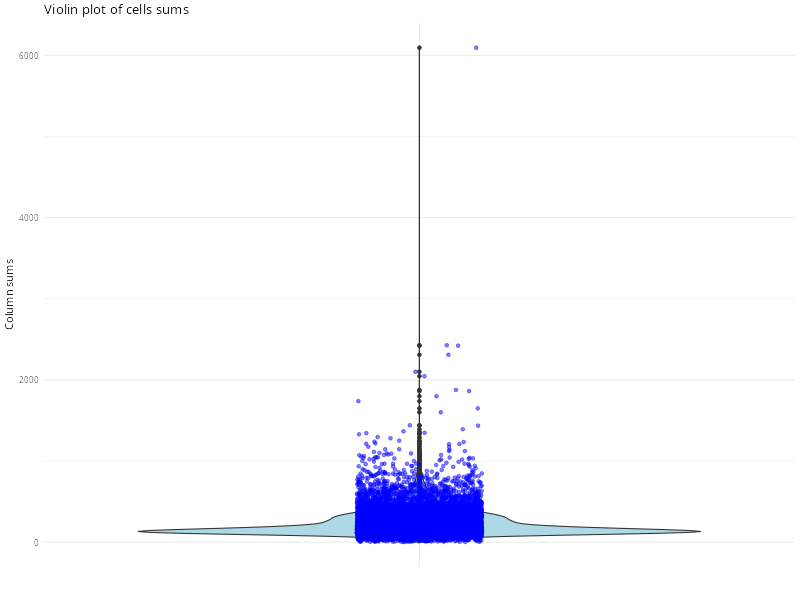

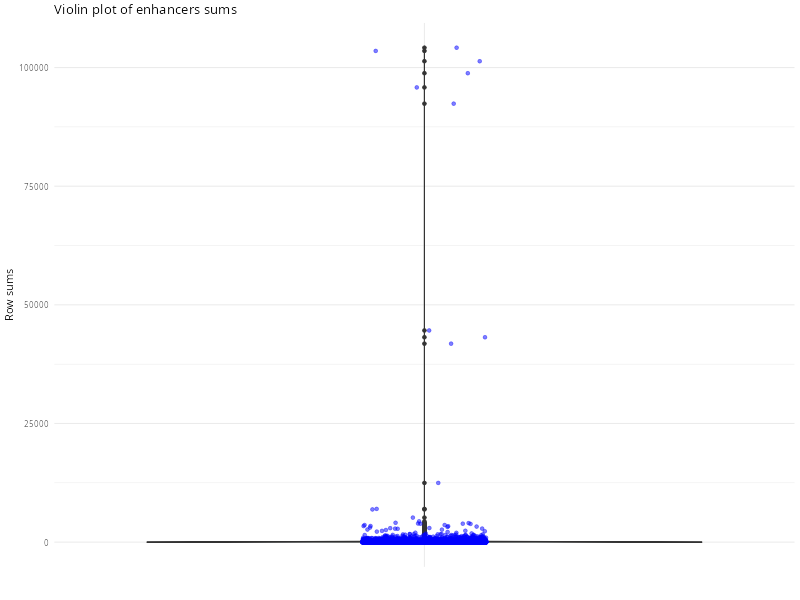

In [ ]:
# violin plot of column sums with jittered points
data_cols = data.frame(sum = colSums(rna_enhancers))
p = ggplot(data_cols, aes(x = "", y = sum)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen") +
  geom_jitter(width = 0.1, alpha = 0.5, color = "blue",height = 0) +
  labs(title = "Violin plot of cells sums", x = "", y = "Column sums") +
  theme_minimal()

print(p)
# violin plot of row sums
data_rows = data.frame(sum = rowSums(rna_enhancers))
p = ggplot(data_rows, aes(x = "", y = sum)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen") +
  geom_jitter(width = 0.1, alpha = 0.5, color = "blue",height = 0) +
  labs(title = "Violin plot of enhancers sums", x = "", y = "Row sums") +
  theme_minimal()
print(p)


# Metadata

In [ ]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = TRUE, sep = "\t", data.table = FALSE)

In [ ]:
names(enhancers_metadata) <- c("chr", "start", "end", "id", "type", "gene_intersection", "bp_to_closest_gene", "length")
head(enhancers_metadata)

  chr  start    end         id     type gene_intersection bp_to_closest_gene length
1   1  25830  26342  ENSR1_B5Q enhancer        intergenic              39077    512
2   1  31906  32843  ENSR1_B6N enhancer        intergenic              32576    937
3   1  38557  38851  ENSR1_9F7 enhancer        intergenic              26568    294
4   1 137201 137378 ENSR1_84XG enhancer        intergenic              65617    177
5   1 143913 144128 ENSR1_854C enhancer        intergenic              72329    215
6   1 179079 179489 ENSR1_93WT enhancer        intergenic             107495    410

In [ ]:
# normalize by length
rna_enhancers_normalized <- rna_enhancers
enhancers_length_vector <- enhancers_metadata$length[match(rownames(rna_enhancers), enhancers_metadata$id)]
rna_enhancers_normalized@x <- rna_enhancers_normalized@x / enhancers_length_vector[rna_enhancers_normalized@i + 1]


In [ ]:
#Normalize to TPM
#rna_enhancers_normalized = rna_enhancers_normalized/colSums(rna_enhancers_normalized) * 1e6 # TPM normalization

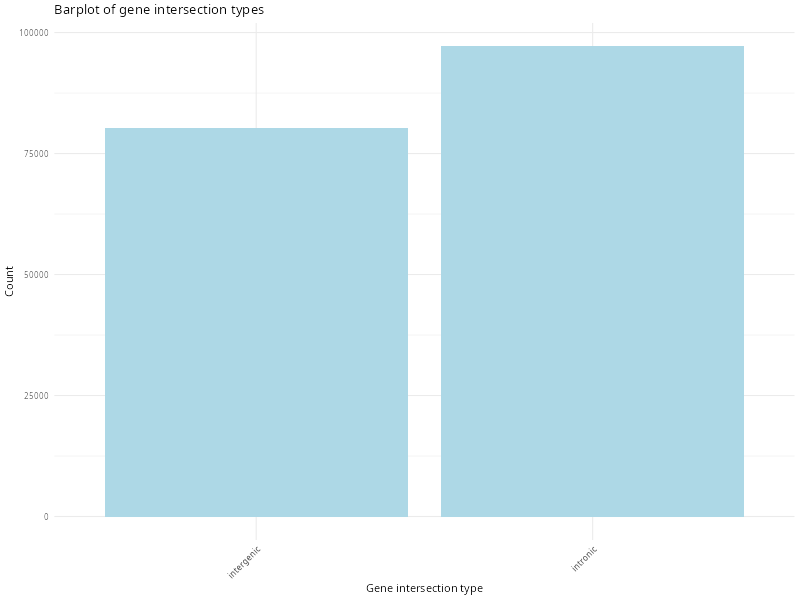

In [ ]:
#barbplot of gene_intersection types
p = ggplot(enhancers_metadata, aes(x = gene_intersection)) +
  geom_bar(fill = "lightblue") +
  labs(title = "Barplot of gene intersection types", x = "Gene intersection type", y = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
p

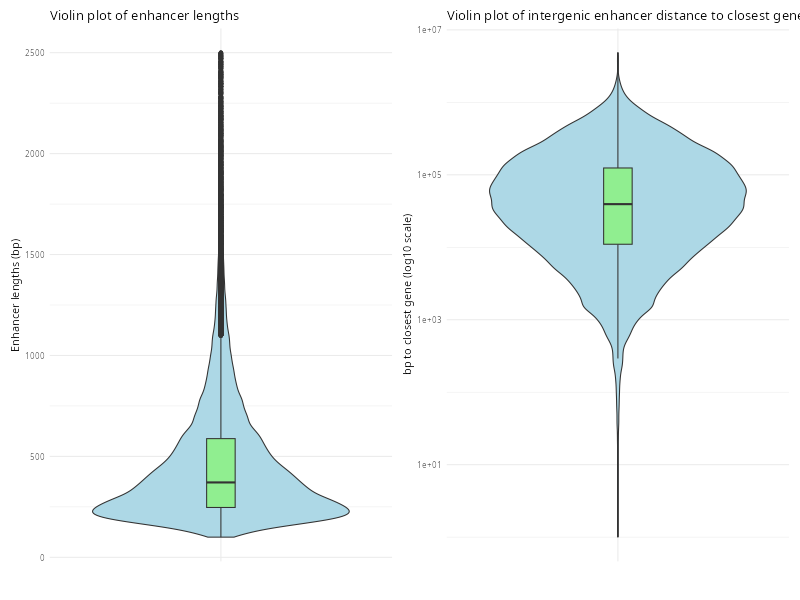

In [ ]:
#violin plots of enhancer lengths 
p1 = ggplot(enhancers_metadata, aes(x = "", y = length)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen") +
  labs(title = "Violin plot of enhancer lengths", x = "", y = "Enhancer lengths (bp)") +
  theme_minimal()

#violin plots of enhancer distance to closest gene
p2 = ggplot(filter(enhancers_metadata,gene_intersection == "intergenic"), aes(x = "", y = bp_to_closest_gene)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen", outlier.shape = NA) +
  scale_y_log10() +  # Transform y-axis to log10 scale
  #ylim(NA, 10000) +   # Set maximum y-axis value to 1000
  labs(title = "Violin plot of intergenic enhancer distance to closest gene", x = "", y = "bp to closest gene (log10 scale)") +
  theme_minimal()
print(p1+p2)

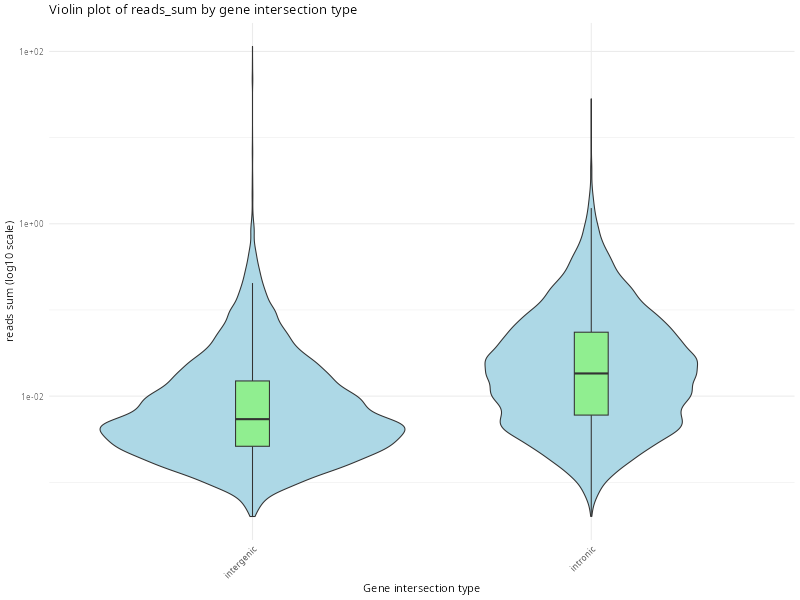

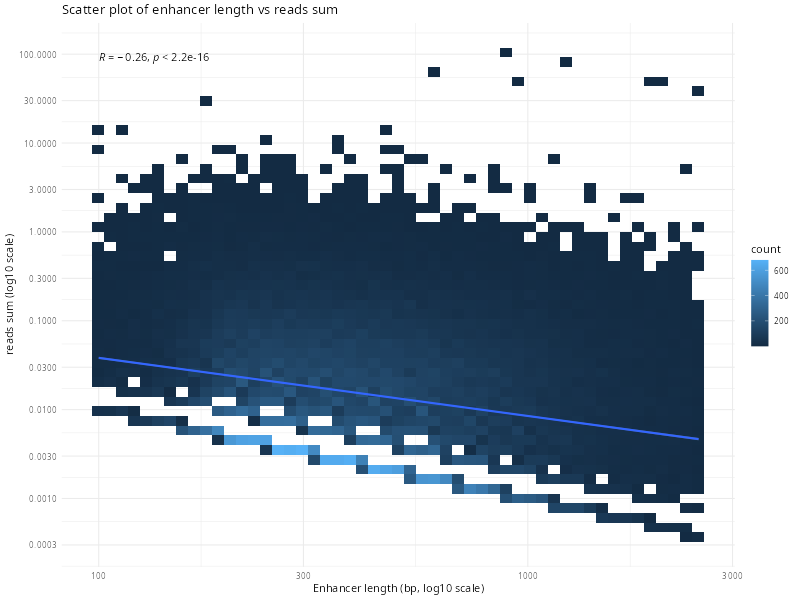

In [ ]:
library(scales)
counts_per_enhancer = data.frame(row.names = rownames(rna_enhancers_normalized), reads_sum = rowSums(rna_enhancers_normalized))
counts_per_enhancer = merge(counts_per_enhancer, enhancers_metadata, by.x = "row.names", by.y = "id")
colnames(counts_per_enhancer)[1] <- "id"
#violin plot of average expression by gene intersection type
p = ggplot(counts_per_enhancer, aes(x = gene_intersection, y = reads_sum)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen", outlier.shape = NA) +
  scale_y_log10() +  # Transform y-axis to log10 scale
  labs(title = "Violin plot of reads_sum by gene intersection type", x = "Gene intersection type", y = "reads sum (log10 scale)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)

p = ggplot(counts_per_enhancer, aes(x = length, y = reads_sum)) +
  geom_bin2d(bins = 50) +
  scale_x_log10() +  # Transform x-axis to log10 scale
  scale_y_continuous(breaks = breaks_log(n = 10),trans = "log10",labels = label_number( big.mark = ",")) +  # Add y-axis ticks at regular intervals
  labs(title = "Scatter plot of enhancer length vs reads sum", x = "Enhancer length (bp, log10 scale)", y = "reads sum (log10 scale)") +
  theme_minimal()+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor()
print(p)


# Filter

In [ ]:
# keep only enhancers that expressed in at least min_cells cells
rows_to_keep = which(rowSums(rna_enhancers_normalized >= 1) >= min_cells)
print(length(rows_to_keep))
print( "enhancers out of " )
print(nrow(rna_enharna_enhancers_normalizedncers))

# keep only cells that expressed in at least min_enhancers enhancers
cols_to_keep = which(colSums(rna_enhancers_normalized >= 1) >= min_enhancers)
print(length(cols_to_keep))
print( "cells out of " )
print(ncol(rna_enhancers_normalized))


[1] 29683
[1] "enhancers out of "
[1] 81246
[1] 11868
[1] "cells out of "
[1] 11907


In [ ]:
rna_enhancers_normalized = rna_enhancers_normalized[rows_to_keep, cols_to_keep]

In [ ]:
saveRDS(rna_enhancers_normalized, file = filtered_erna_path)